In [76]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

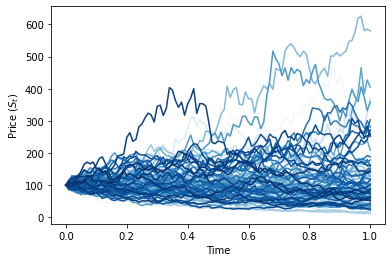

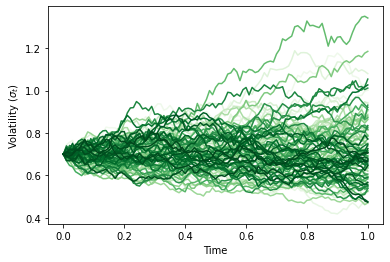

In [73]:
def simulate_asset_price(S0, r, sigma0, alpha, T, num_steps, num_simulations):
    dt = T / num_steps
    sqrt_dt = np.sqrt(dt)

    asset_prices = np.zeros((num_steps + 1, num_simulations))
    asset_prices[0] = S0

    volatilities = np.zeros((num_steps + 1, num_simulations))
    volatilities[0] = sigma0

    for i in range(1, num_steps + 1):
        z_asset = np.random.normal(0, 1, num_simulations)
        dW_asset = sqrt_dt * z_asset

        z_volatility = np.random.normal(0, 1, num_simulations)
        dW_volatility = sqrt_dt * z_volatility

        sigma_t = volatilities[i - 1] * np.exp(-0.5 * alpha**2 * dt + alpha * dW_volatility)
        asset_prices[i] = asset_prices[i - 1] * np.exp((r - 0.5 * sigma_t**2) * dt + sigma_t * dW_asset)
        volatilities[i] = sigma_t

    return asset_prices, volatilities

S0 = 100
r = 0
sigma0 = 0.7
alpha = 0.2
T = 1
num_steps = 100
num_simulations = 100
num_simulations_MC = 100

# Generar precios de activos y volatilidades simuladas
asset_prices, volatilities = simulate_asset_price(S0, r, sigma0, alpha, T, num_steps, num_simulations)

# Colores en tonos azulados
cmap = plt.get_cmap('Blues')

# Gráfico del precio del activo en función del tiempo
time = np.linspace(0, T, num_steps + 1)
for i in range(num_simulations):
    plt.plot(time, asset_prices[:, i], color=cmap(i / num_simulations))

plt.xlabel('Time')
plt.ylabel(r'Price ($S_{t}$)')
plt.title('')
plt.show()

cmap = plt.get_cmap('Greens')

# Gráfico de la volatilidad en función del tiempo
for i in range(num_simulations):
    plt.plot(time, volatilities[:, i], color=cmap(i / num_simulations))

plt.xlabel('Time')
plt.ylabel(r'Volatility ($\sigma_{t}$)')
plt.title('')
plt.show()



In [51]:
def monte_carlo_option_pricing(S, K, r, sigma0, alpha, T, num_simulations, option_type):
    option_prices = []
    for _ in range(num_simulations):
        W1 = np.random.standard_normal()
        W2 = np.random.standard_normal()
        sigma_T = sigma0 * np.exp(-0.5 * alpha**2 * T + alpha * W1 * np.sqrt(T))
        S_T = S * np.exp((r - 0.5 * sigma_T**2) * T + sigma_T * W2 * np.sqrt(T))
        
        if option_type == 'call':
            option_price = max(S_T - K, 0)
        elif option_type == 'put':
            option_price = max(K - S_T, 0)
        option_prices.append(option_price)
    
    # Compute the average option price across all simulations
    estimated_price = np.mean(option_prices) * np.exp(-r * T)
    return estimated_price


Calculation of $2\int_{0}^{F_{0}}\frac{1}{K^{2}}P_{BS}(K)dK+2\int_{F_{0}}^{\infty}\frac{1}{K^{2}}C_{BS}(K)dK$

In [52]:
def static_replication_pricing(S0,r, sigma0, alpha, T,num_simulations_MC):
    strikes_calls = np.linspace(100,200,100)
    call_sum = 0
    for strike_call in strikes_calls:
        call_price = monte_carlo_option_pricing(S0, strike_call, r, sigma0, alpha, T, num_simulations_MC, option_type='call')
        call_sum += (1/strike_call**2)*call_price
    strikes_puts = np.linspace(1,100,100)
    put_sum = 0
    for strike_put in strikes_puts:
        put_price = monte_carlo_option_pricing(S0, strike_put, r, sigma0, alpha, T, num_simulations, option_type='put')
        put_sum += (1/strike_put**2)*put_price
    return 2*put_sum+2*call_sum


Calculation of $\sum_{i=1}^{m}ln^{2}\left(\frac{S_{i}}{S_{i-1}}\right)$

In [53]:
import numpy as np

def realized_variance(S0, r, sigma0, alpha, T, num_steps):
    dt = T / num_steps
    sqrt_dt = np.sqrt(dt)

    asset_prices = np.zeros(num_steps + 1)
    asset_prices[0] = S0

    sigma = np.zeros(num_steps + 1)
    sigma[0] = sigma0

    log_returns = np.zeros(num_steps)

    for i in range(1, num_steps + 1):
        z_price = np.random.normal(0, 1)
        z_volatility = np.random.normal(0, 1)

        sigma_t = sigma[i - 1] * np.exp(-0.5 * alpha**2 * dt + alpha * sqrt_dt * z_volatility)
        asset_prices[i] = asset_prices[i - 1] * np.exp((r - 0.5 * sigma_t**2) * dt + sigma_t * sqrt_dt * z_price)
        sigma[i] = sigma_t

        log_returns[i - 1] = np.log(asset_prices[i] / asset_prices[i - 1])

    realized_variance = np.sum(log_returns**2)

    return realized_variance


Distribution of $\sum_{i=1}^{m}ln^{2}\left(\frac{S_{i}}{S_{i-1}}\right)$ and $2\int_{0}^{F_{0}}\frac{1}{K^{2}}P_{BS}(K)dK+2\int_{F_{0}}^{\infty}\frac{1}{K^{2}}C_{BS}(K)dK$

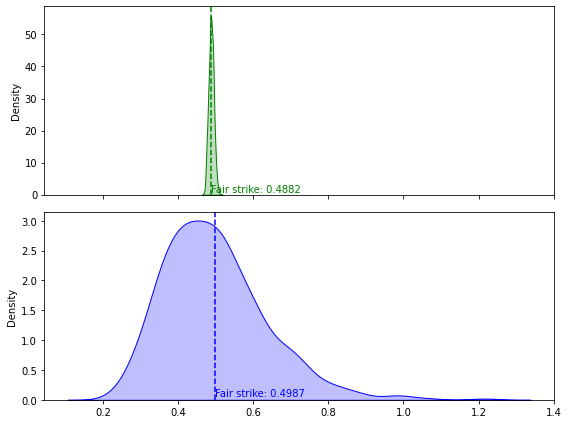

In [54]:
portfolio_values = []
realized_vars = []

for _ in range(num_simulations):
    portfolio_value = static_replication_pricing(S0, r, sigma0, alpha, T, num_simulations_MC)
    portfolio_values.append(portfolio_value)

for _ in range(num_simulations):
    realized_var = realized_variance(S0, r, sigma0, alpha, T, num_steps)
    realized_vars.append(realized_var)
    
fair_strike_byreplication = np.mean(portfolio_values)
fair_strike_byestimation = np.mean(realized_vars)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6))

sns.kdeplot(portfolio_values, shade=True, color='green', ax=ax1)
ax1.axvline(fair_strike_byreplication, linestyle='--', color='green')
ax1.text(fair_strike_byreplication, 0.02, f'Fair strike: {fair_strike_byreplication:.4f}', color='green', verticalalignment='bottom', horizontalalignment='left')
ax1.set_ylabel('Density')
ax1.set_xlabel(r'Value of the replicating portfolio')
ax1.set_title('')

sns.kdeplot(realized_vars, shade=True, color='blue', ax=ax2)
ax2.axvline(fair_strike_byestimation, linestyle='--', color='blue')
ax2.text(fair_strike_byestimation, 0.02, f'Fair strike: {fair_strike_byestimation:.4f}', color='blue', verticalalignment='bottom', horizontalalignment='left')
ax2.set_xlabel(r'')
ax2.set_ylabel('Density')
ax2.set_title('')

plt.tight_layout()
plt.show()


Pricing volatility swaps: $E\sqrt{\int^{T}_{0}\sigma^{2}_{s}ds}$ by replication and estimation

In [56]:
conv_adj_num = np.mean((portfolio_values-fair_strike_byreplication)**2)
conv_adj_den = -8*(np.sqrt(fair_strike_byreplication))**3

volswap_fs_rep = np.sqrt(fair_strike_byreplication)+conv_adj_num/conv_adj_den
volswap_fs_rep

0.6987002187287056

In [67]:
realized_vols=[]
for _ in range(num_simulations):
    realized_vol = np.sqrt(realized_variance(S0, r, sigma0, alpha, T, num_steps))
    realized_vols.append(realized_vol)
    

fair_strike_byestimation = np.mean(realized_vols)
fair_strike_byestimation

0.6955980380087399

In [77]:
jupyter nbconvert --to latex your_notebook.ipynb


SyntaxError: invalid syntax (2280688557.py, line 1)